<a href="https://www.kaggle.com/code/bollaa/object-detection?scriptVersionId=238986009" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Loading Data

In [1]:
# Cell 1: Imports & Configuration
import os
import random
import xml.etree.ElementTree as ET

import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Set random seeds for reproducibility
random.seed(42)
torch.manual_seed(42)

# Paths to your mounted Kaggle dataset
IMG_DIR = '/kaggle/input/hard-hat-detection/images'
ANN_DIR = '/kaggle/input/hard-hat-detection/annotations'

# Define number of classes (3 classes + background)
NUM_CLASSES = 3 + 1  # helmet, person, head, plus background



#  Create Train / Validation Split

In [2]:
# Cell 2: Create Train/Val Splits
# 1) List all image files that have a matching .xml annotation
all_files = [
    f for f in os.listdir(IMG_DIR)
    if os.path.splitext(f)[1].lower() in ('.jpg', '.png')
    and os.path.exists(os.path.join(ANN_DIR, os.path.splitext(f)[0] + '.xml'))
]
# 2) Shuffle and split 80/20
random.shuffle(all_files)
split_idx = int(0.8 * len(all_files))
train_files, val_files = all_files[:split_idx], all_files[split_idx:]

print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")


Training samples: 4000
Validation samples: 1000


# Preproccesing

In [3]:
# Cell 3: Dataset Definition
class HardHatDataset(Dataset):
    """
    PyTorch Dataset for Pascal VOC–style Hard Hat annotations.
    Returns an image tensor and a dict with 'boxes' & 'labels'.
    """
    def __init__(self, file_list, img_dir, ann_dir, transforms=None):
        self.file_list = file_list
        self.img_dir   = img_dir
        self.ann_dir   = ann_dir
        self.transforms = transforms
        # Map class names to indices (background=0 by convention in Faster R-CNN)
        self.class_map = {'helmet':1, 'person':2, 'head':3}

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # 1. Load image
        fname    = self.file_list[idx]
        img_path = os.path.join(self.img_dir, fname)
        img_bgr  = cv2.imread(img_path)
        img      = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        # 2. Parse XML annotation
        xml_path = os.path.join(self.ann_dir, os.path.splitext(fname)[0] + '.xml')
        tree     = ET.parse(xml_path)
        root     = tree.getroot()

        boxes, labels = [], []
        for obj in root.findall('object'):
            cls_name = obj.find('name').text
            labels.append(self.class_map[cls_name])
            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])

        # 3. Convert to torch tensors
        boxes  = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        target = {'boxes': boxes, 'labels': labels}

        # 4. Apply any augmentations
        if self.transforms:
            augmented = self.transforms(image=img, bboxes=boxes.numpy(), labels=labels.numpy())
            img        = augmented['image']
            boxes      = torch.tensor(augmented['bboxes'], dtype=torch.float32)
            labels     = torch.tensor(augmented['labels'], dtype=torch.int64)
            target     = {'boxes': boxes, 'labels': labels}

        # 5. To tensor & normalize to [0,1]
        img = transforms.ToTensor()(img)
        return img, target


In [48]:
# Cell 4: Collate Function & DataLoaders
def collate_fn(batch):
    """Custom collate to handle batches of images with variable # of boxes."""
    images, targets = list(zip(*batch))
    return images, targets

# Instantiate datasets
train_ds = HardHatDataset(train_files, IMG_DIR, ANN_DIR, transforms=None)
val_ds   = HardHatDataset(val_files,   IMG_DIR, ANN_DIR, transforms=None)

# DataLoaders for batching
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,
                          collate_fn=collate_fn, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=True,
                          collate_fn=collate_fn, num_workers=2)


# Model 1

In [5]:
# Cell 5: Model #1 – Faster R-CNN w/ ResNet-50 Backbone
# Load pre-trained Faster R-CNN
model_resnet = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classifier head with the correct # of classes
in_features = model_resnet.roi_heads.box_predictor.cls_score.in_features
model_resnet.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

# Move to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_resnet = model_resnet.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 214MB/s] 


# Model 2

In [6]:
# Cell 6: Model #2 – Faster R-CNN w/ MobileNet V2 Backbone
# Build Faster R-CNN from backbone manually
backbone = models.mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280  # MobileNet V2 feature dimension

from torchvision.models.detection.rpn import AnchorGenerator
# Use default anchor sizes & aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

from torchvision.models.detection import FasterRCNN
from torchvision.ops import MultiScaleRoIAlign

roi_pooler = MultiScaleRoIAlign(
    featmap_names=['0'], output_size=7, sampling_ratio=2
)

model_mobilenet = FasterRCNN(
    backbone,
    num_classes=NUM_CLASSES,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

model_mobilenet = model_mobilenet.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 149MB/s]


# Training

In [7]:
# Cell 7: Training Loop Skeleton
import torch.optim as optim

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    for images, targets in loader:
        images = [img.to(device) for img in images]
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

# Create optimizers
opt_resnet    = optim.SGD(model_resnet.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
opt_mobilenet = optim.SGD(model_mobilenet.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)

# Example: one epoch for each
resnet_loss    = train_one_epoch(model_resnet,    train_loader, opt_resnet,    device)
mobilenet_loss = train_one_epoch(model_mobilenet, train_loader, opt_mobilenet, device)
print(f"ResNet-50 Loss: {resnet_loss:.4f}, MobileNet V2 Loss: {mobilenet_loss:.4f}")


ResNet-50 Loss: 0.4970, MobileNet V2 Loss: 0.3592


In [8]:
# Cell 8: Full Multi-Epoch Training Loop

from tqdm.auto import tqdm

def train_one_epoch_verbose(model, loader, optimizer, device, epoch, num_epochs):
    model.train()
    running_loss = 0.0
    total_batches = len(loader)
    # tqdm shows a nice progress bar with percentage
    pbar = tqdm(enumerate(loader, 1), total=total_batches,
                desc=f"Epoch [{epoch}/{num_epochs}]", leave=False)
    
    for batch_idx, (images, targets) in pbar:
        # Move inputs to device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward + loss
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update running stats
        running_loss += loss.item()
        avg_loss = running_loss / batch_idx
        
        # Update the bar
        pbar.set_postfix({
            "batch_loss": f"{loss.item():.4f}",
            "avg_loss":   f"{avg_loss:.4f}",
            "progress":   f"{batch_idx/total_batches*100:.1f}%"
        })
    
    return running_loss / total_batches

# Now loop epochs for both models
NUM_EPOCHS = 10

for model_name, model, optimizer in [
    ('ResNet50',    model_resnet,    opt_resnet),
    ('MobileNetV2', model_mobilenet, opt_mobilenet)
]:
    print(f"\n=== Training {model_name} ===")
    for epoch in range(1, NUM_EPOCHS + 1):
        epoch_loss = train_one_epoch_verbose(
            model, train_loader, optimizer, device, epoch, NUM_EPOCHS
        )
        print(f"Epoch {epoch}/{NUM_EPOCHS} — Avg Loss: {epoch_loss:.4f}")




=== Training ResNet50 ===


Epoch [1/10]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/10 — Avg Loss: 0.3664


Epoch [2/10]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/10 — Avg Loss: 0.3433


Epoch [3/10]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3/10 — Avg Loss: 0.3248


Epoch [4/10]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4/10 — Avg Loss: 0.3113


Epoch [5/10]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5/10 — Avg Loss: 0.2984


Epoch [6/10]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6/10 — Avg Loss: 0.2871


Epoch [7/10]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7/10 — Avg Loss: 0.2767


Epoch [8/10]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8/10 — Avg Loss: 0.2661


Epoch [9/10]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9/10 — Avg Loss: 0.2566


Epoch [10/10]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10/10 — Avg Loss: 0.2464

=== Training MobileNetV2 ===


Epoch [1/10]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/10 — Avg Loss: 0.3042


Epoch [2/10]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/10 — Avg Loss: 0.2884


Epoch [3/10]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3/10 — Avg Loss: 0.2785


Epoch [4/10]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4/10 — Avg Loss: 0.2699


Epoch [5/10]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5/10 — Avg Loss: 0.2641


Epoch [6/10]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6/10 — Avg Loss: 0.2565


Epoch [7/10]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7/10 — Avg Loss: 0.2485


Epoch [8/10]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8/10 — Avg Loss: 0.2421


Epoch [9/10]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9/10 — Avg Loss: 0.2381


Epoch [10/10]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10/10 — Avg Loss: 0.2322


In [36]:
# Cell: Save both trained models to disk

import torch

# 1. Save Faster R-CNN with ResNet-50 backbone
resnet_path = 'fasterrcnn_resnet50_fpn_hardhat.pth'
torch.save(model_resnet.state_dict(), resnet_path)
print(f"ResNet-50 model saved to {resnet_path}")

# 2. Save Faster R-CNN with MobileNet V2 backbone
mobilenet_path = 'fasterrcnn_mobilenet_v2_hardhat.pth'
torch.save(model_mobilenet.state_dict(), mobilenet_path)
print(f"MobileNet V2 model saved to {mobilenet_path}")


ResNet-50 model saved to fasterrcnn_resnet50_fpn_hardhat.pth
MobileNet V2 model saved to fasterrcnn_mobilenet_v2_hardhat.pth


In [17]:
# Cell: Create reverse mapping
REV_CLASS_MAP = {0: 'background', 1: 'helmet', 2: 'person', 3: 'head'}


In [14]:
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def get_prediction(model, images, device, threshold=0.5):
    model.eval()
    with torch.no_grad():
        # Move each image to device
        images = [img.to(device) for img in images]
        outputs = model(images)

    # Take predictions for the first image in the batch
    pred = outputs[0]
    boxes = pred['boxes'].cpu().numpy()
    labels = pred['labels'].cpu().numpy()
    scores = pred['scores'].cpu().numpy()

    selected = scores >= threshold
    return boxes[selected], labels[selected], scores[selected]


In [18]:
# Cell: Updated plot_prediction to use names
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_prediction(image_tensor, boxes, labels, scores, rev_map=REV_CLASS_MAP):
    """
    image_tensor:    torch tensor [C,H,W]
    boxes:           numpy array [[xmin,ymin,xmax,ymax], ...]
    labels/scores:   numpy arrays
    rev_map:         dict mapping label int -> class name
    """
    img = image_tensor.permute(1, 2, 0).cpu().numpy()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)
    
    for box, lbl, score in zip(boxes, labels, scores):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        class_name = rev_map.get(lbl, str(lbl))
        ax.text(xmin, ymin - 5, f'{class_name}: {score:.2f}',
                color='white', fontsize=12,
                bbox=dict(facecolor='red', alpha=0.5))
    plt.axis('off')
    plt.show()


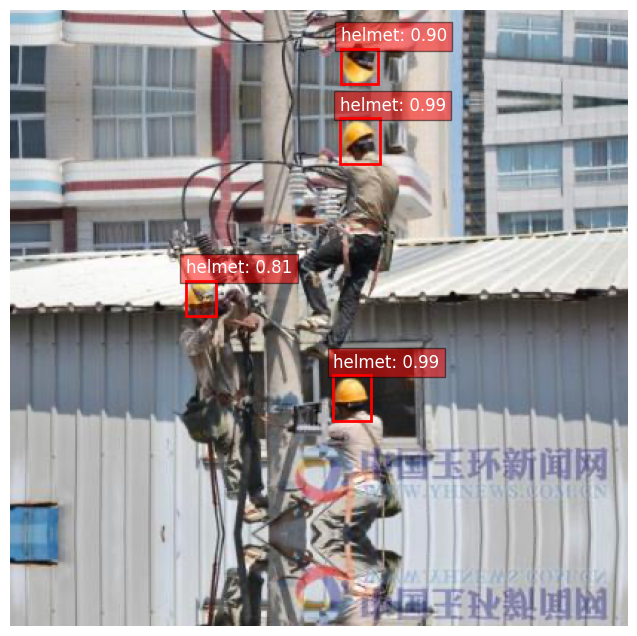

In [24]:
# Get one batch from the validation loader
images, targets = next(iter(val_loader))

# Pick one image
image = images[1]

# Run prediction
boxes, labels, scores = get_prediction(model_mobilenet, [image], device)

# Visualize
plot_prediction(image, boxes, labels, scores)


# Evaluation

In [37]:

import os, json, cv2, xml.etree.ElementTree as ET

# reverse map from your training code
REV_CLASS_MAP = {0: 'background', 1: 'helmet', 2: 'person', 3: 'head'}

def voc_to_coco_json(img_list, img_dir, ann_dir, rev_map, output_path):
    coco = {"images": [], "annotations": [], "categories": []}
    # categories (skip background)
    for cid, name in rev_map.items():
        if cid == 0: continue
        coco["categories"].append({"id": cid, "name": name})
    ann_id = 1
    for img_id, fname in enumerate(img_list, start=1):
        root, ext = os.path.splitext(fname)
        xml_path = os.path.join(ann_dir, root + '.xml')
        if not os.path.exists(xml_path): 
            continue
        # image info
        img_path = os.path.join(img_dir, fname)
        h, w = cv2.imread(img_path).shape[:2]
        coco["images"].append({
            "id": img_id, "file_name": fname, "height": h, "width": w
        })
        # annotations
        tree = ET.parse(xml_path)
        for obj in tree.getroot().findall('object'):
            cls = obj.find('name').text
            cid = {v:k for k,v in rev_map.items()}[cls]
            bb  = obj.find('bndbox')
            xmin, ymin = float(bb.find('xmin').text), float(bb.find('ymin').text)
            xmax, ymax = float(bb.find('xmax').text), float(bb.find('ymax').text)
            w_box, h_box = xmax - xmin, ymax - ymin
            coco["annotations"].append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": cid,
                "bbox": [xmin, ymin, w_box, h_box],
                "area": w_box * h_box,
                "iscrowd": 0
            })
            ann_id += 1

    with open(output_path, 'w') as f:
        json.dump(coco, f)
    print(f"COCO GT JSON saved to {output_path}")

# Run it
voc_to_coco_json(val_files, IMG_DIR, ANN_DIR, REV_CLASS_MAP, 'val_gt.json')


COCO GT JSON saved to val_gt.json


In [38]:

import os, json, cv2
from torchvision import transforms

def run_and_save_preds(model, model_name, img_list, img_dir, device, threshold, out_path):
    preds = []
    for img_id, fname in enumerate(img_list, start=1):
        root, _ = os.path.splitext(fname)
        xml_path = os.path.join(ANN_DIR, root + '.xml')
        if not os.path.exists(xml_path):
            continue
        # load image
        img = cv2.cvtColor(cv2.imread(os.path.join(img_dir, fname)), cv2.COLOR_BGR2RGB)
        tensor = transforms.ToTensor()(img).to(device)
        # predict
        boxes, labels, scores = get_prediction(model, [tensor], device, threshold)
        # record
        for box, lbl, score in zip(boxes, labels, scores):
            xmin, ymin, xmax, ymax = box
            preds.append({
                "image_id": img_id,
                "category_id": int(lbl),
                "bbox": [float(xmin), float(ymin), float(xmax - xmin), float(ymax - ymin)],
                "score": float(score)
            })
    with open(out_path, 'w') as f:
        json.dump(preds, f)
    print(f"{model_name} predictions saved to {out_path}")

# Save for both models at 0.5 score threshold
run_and_save_preds(model_resnet,    'ResNet50',    val_files, IMG_DIR, device, 0.5, 'resnet_preds.json')
run_and_save_preds(model_mobilenet, 'MobileNetV2', val_files, IMG_DIR, device, 0.5, 'mobilenet_preds.json')


ResNet50 predictions saved to resnet_preds.json
MobileNetV2 predictions saved to mobilenet_preds.json


In [39]:
#  Compute mAP@0.5 & @0.75 with pycocotools

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

def coco_eval(gt_path, dt_path, iou_thrs):
    cocoGt = COCO(gt_path)
    cocoDt = cocoGt.loadRes(dt_path)
    cocoEval = COCOeval(cocoGt, cocoDt, 'bbox')
    cocoEval.params.iouThrs = iou_thrs
    cocoEval.evaluate()
    cocoEval.accumulate()
    print(f"\n---- Evaluation for {os.path.basename(dt_path)} ----")
    cocoEval.summarize()

# Evaluate both models
coco_eval('val_gt.json',     'resnet_preds.json',    [0.5, 0.75])
coco_eval('val_gt.json',     'mobilenet_preds.json', [0.5, 0.75])


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.21s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.46s).
Accumulating evaluation results...
DONE (t=0.08s).

---- Evaluation for resnet_preds.json ----
 Average Precision  (AP) @[ IoU=0.50:0.75 | area=   all | maxDets=100 ] = 0.501
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.75 | area= small | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50:0.75 | area=medium | maxDets=100 ] = 0.573
 Average Precision  (AP) @[ IoU=0.50:0.75 | area= large | maxDets=100 ] = 0.625
 Average Recall     (AR) @[ IoU=0.50:0.75 | area=   all | maxDets=  1 ] = 0.131
 Average Recall     (AR) @[ IoU=0.50:0.75 | area=   all | maxDets= 10 ] = 0.511
 Average Recall    

In [109]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import torchvision.transforms as T

def get_predictions(model, img, device, threshold=0.2):
    """
    Run the model on a single PIL image, return boxes, labels & scores
    above the threshold.
    """
    model.eval()
    transform = T.ToTensor()
    img_t = transform(img).to(device)
    with torch.no_grad():
        outputs = model([img_t])
    outputs = outputs[0]
    # move to CPU & filter by score
    boxes  = outputs['boxes'].cpu()
    labels = outputs['labels'].cpu()
    scores = outputs['scores'].cpu()
    keep   = scores >= threshold
    return boxes[keep], labels[keep], scores[keep]

def draw_boxes_on_image(img, boxes, labels, scores, rev_map):
    """
    Draw red bboxes + class labels (with scores) onto a copy of the PIL image,
    measuring text with font.getbbox().
    """
    img = img.copy()
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype("arial.ttf", size=15)
    except IOError:
        font = ImageFont.load_default()
    
    for box, lbl, sc in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box
        cls_name = rev_map[int(lbl)]
        text = f"{cls_name} {sc:.2f}"
        
        # get text bbox (x0, y0, x1, y1)
        x0, y0, x1b, y1b = font.getbbox(text)
        text_width  = x1b - x0
        text_height = y1b - y0
        
        # draw bounding box
        draw.rectangle([box[0], box[1], box[2], box[3]], outline="red", width=2)
        
        # draw background rectangle for text
        text_origin = (box[0], box[1] - text_height)
        draw.rectangle([
            text_origin,
            (text_origin[0] + text_width, text_origin[1] + text_height)
        ], fill="red")
        
        # draw text
        draw.text(text_origin, text, fill="white", font=font)
    
    return img

def compare_models_on_images(models, model_names, img_paths, device, rev_map, threshold=0.2):
    """
    For each image in img_paths, runs each model and plots side-by-side.
    """
    n_images = len(img_paths)
    n_models = len(models)
    fig, axes = plt.subplots(n_images, n_models,
                             figsize=(5 * n_models, 5 * n_images),
                             squeeze=False)
    
    for i, img_path in enumerate(img_paths):
        img = Image.open(img_path).convert("RGB")
        for j, (model, name) in enumerate(zip(models, model_names)):
            ax = axes[i][j]
            ax.set_title(f"{name}\n{os.path.basename(img_path)}", fontsize=10)
            boxes, labels, scores = get_predictions(model, img, device, threshold)
            viz = draw_boxes_on_image(img, boxes, labels, scores, rev_map)
            ax.imshow(viz)
            ax.axis("off")
    
    plt.tight_layout()
    plt.show()


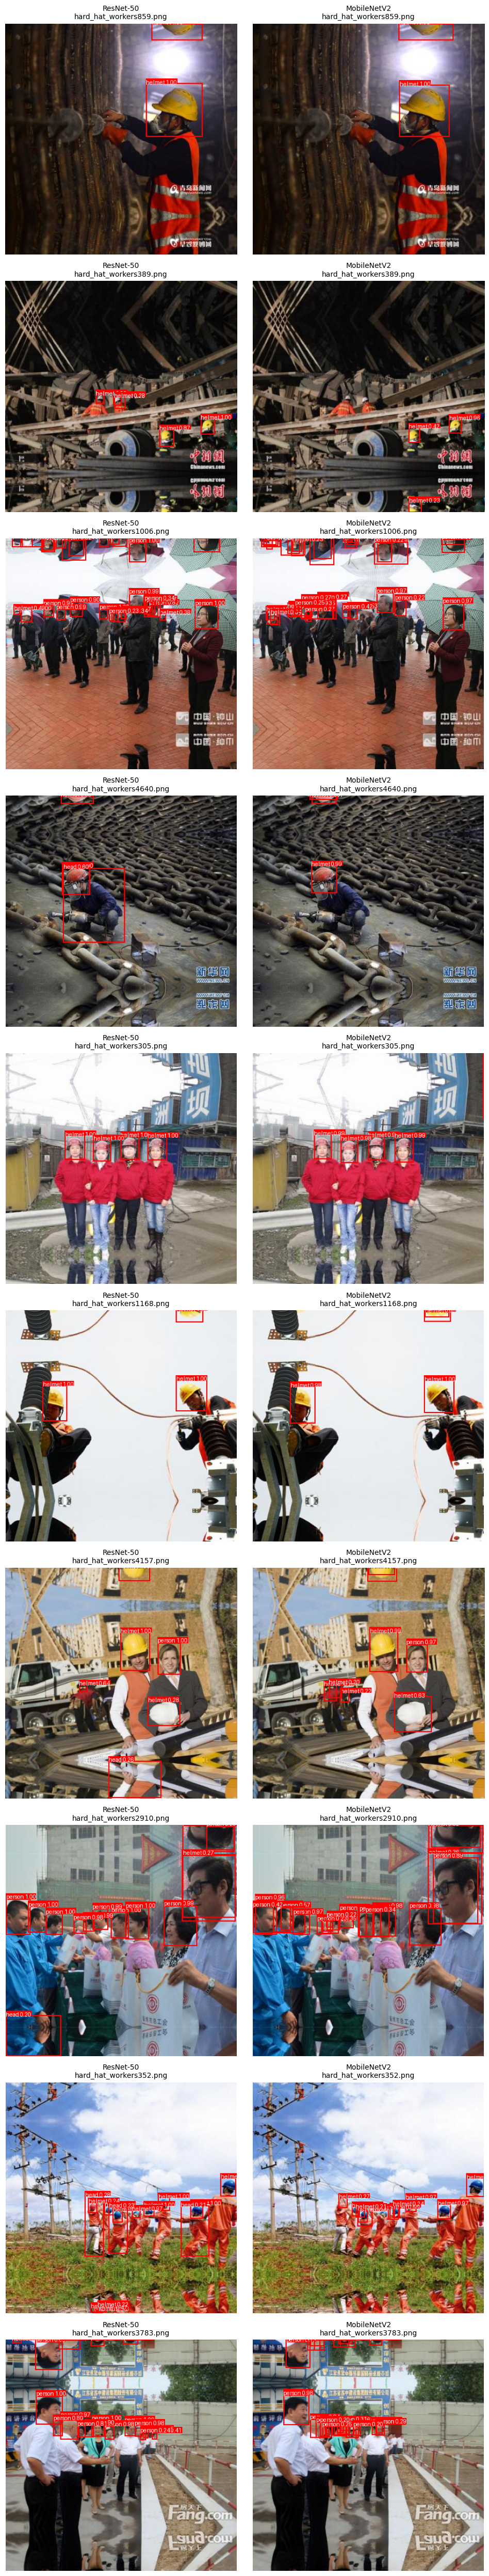

In [110]:
import random, os

sample = random.sample(val_files, k=10)
val_image_paths = [os.path.join(IMG_DIR, f) for f in sample]

compare_models_on_images(
    models      = [model_resnet, model_mobilenet],
    model_names = ['ResNet-50', 'MobileNetV2'],
    img_paths   = val_image_paths,
    device      = device,
    rev_map     = REV_CLASS_MAP,
    threshold   = 0.2
)


In [60]:
# Latency 

import time
import torch

def benchmark_model(model, data_loader, device):
    model.to(device).eval()
    timings = []
    with torch.no_grad():
        for imgs, _ in data_loader:
            imgs = [img.to(device) for img in imgs]
            start = time.time()
            _ = model(imgs)
            if device.type == 'cuda':
                torch.cuda.synchronize()
            end = time.time()
            timings.append(end - start)
    avg_time = sum(timings) / len(timings)
    fps = 1.0 / avg_time
    return avg_time, fps

for name, mdl in [('ResNet-50', model_resnet), ('MobileNetV2', model_mobilenet)]:
    latency, fps = benchmark_model(mdl, val_loader, device)
    print(f"{name}: Avg latency {latency*1000:.1f} ms | {fps:.1f} FPS")


ResNet-50: Avg latency 376.6 ms | 2.7 FPS
MobileNetV2: Avg latency 433.6 ms | 2.3 FPS


In [70]:
# Classification Report

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def get_classification_metrics(model, dataloader, device, class_map, threshold=0.5):
    model.eval()
    all_preds = []
    all_targets = []

    num_classes = len(class_map)

    with torch.no_grad():
        for images, targets in dataloader:
            images = list(img.to(device) for img in images)
            outputs = model(images)

            for output, target in zip(outputs, targets):
                gt_labels = target['labels'].cpu().numpy()
                pred_scores = output['scores'].cpu().numpy()
                pred_labels = output['labels'].cpu().numpy()

                pred_labels = pred_labels[pred_scores >= threshold]

                # One-hot encode ground truth and predicted labels
                pred_bin = np.zeros(num_classes, dtype=int)
                gt_bin = np.zeros(num_classes, dtype=int)

                for lbl in pred_labels:
                    if lbl < num_classes:
                        pred_bin[lbl] = 1
                for lbl in gt_labels:
                    if lbl < num_classes:
                        gt_bin[lbl] = 1

                all_preds.append(pred_bin)
                all_targets.append(gt_bin)

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    recall    = recall_score(all_targets, all_preds, average='macro', zero_division=0)
    f1        = f1_score(all_targets, all_preds, average='macro', zero_division=0)
    accuracy  = accuracy_score(all_targets, all_preds)

    return precision, recall, f1, accuracy


In [71]:
# Reconstruct CLASS_MAP from REV_CLASS_MAP
CLASS_MAP = {v: k for k, v in REV_CLASS_MAP.items()}

precision_r, recall_r, f1_r, acc_r = get_classification_metrics(model_resnet, val_loader, device, CLASS_MAP)
precision_m, recall_m, f1_m, acc_m = get_classification_metrics(model_mobilenet, val_loader, device, CLASS_MAP)

metrics_summary = {
    "Model": ["ResNet-50", "MobileNetV2"],
    "Precision": [precision_r, precision_m],
    "Recall": [recall_r, recall_m],
    "F1-score": [f1_r, f1_m],
    "Accuracy": [acc_r, acc_m]
}

import pandas as pd
metrics_df = pd.DataFrame(metrics_summary)
metrics_df


Model  Precision    Recall  F1-score  Accuracy
0    ResNet-50   0.426285  0.528082  0.464325     0.767
1  MobileNetV2   0.427664  0.454517  0.440024     0.862

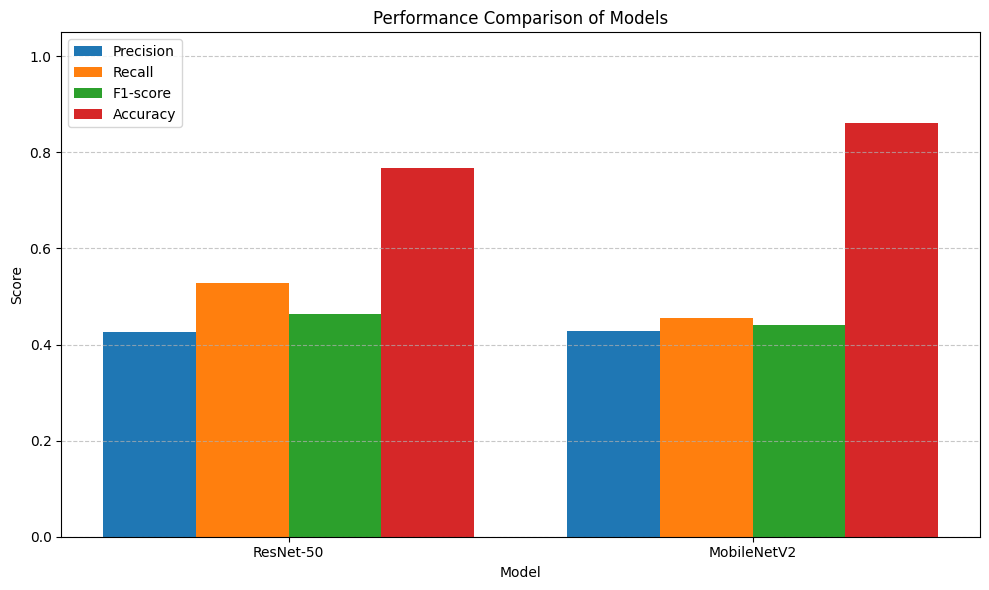

In [72]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(metrics_summary["Model"]))

for i, metric in enumerate(["Precision", "Recall", "F1-score", "Accuracy"]):
    ax.bar(index + i * bar_width,
           metrics_df[metric],
           bar_width,
           label=metric)

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Performance Comparison of Models')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(metrics_summary["Model"])
ax.legend()
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [77]:
# Confusion Matrix

from sklearn.metrics import multilabel_confusion_matrix

def get_per_class_confusion_matrices(model, dataloader, device, class_map, threshold=0.5):
    model.eval()
    all_preds = []
    all_targets = []

    num_classes = len(class_map)

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for output, target in zip(outputs, targets):
                gt_labels = target['labels'].cpu().numpy()
                pred_scores = output['scores'].cpu().numpy()
                pred_labels = output['labels'].cpu().numpy()

                pred_labels = pred_labels[pred_scores >= threshold]

                pred_bin = np.zeros(num_classes, dtype=int)
                gt_bin   = np.zeros(num_classes, dtype=int)

                for lbl in pred_labels:
                    if lbl < num_classes:
                        pred_bin[lbl] = 1
                for lbl in gt_labels:
                    if lbl < num_classes:
                        gt_bin[lbl] = 1

                all_preds.append(pred_bin)
                all_targets.append(gt_bin)

    all_preds   = np.array(all_preds)
    all_targets = np.array(all_targets)

    cm = multilabel_confusion_matrix(all_targets, all_preds)
    return cm


In [74]:
import seaborn as sns

def plot_confusion_matrix(cm, class_map, model_name):
    num_classes = len(class_map)
    class_names = [class_map[i] for i in range(num_classes)]

    fig, axes = plt.subplots(nrows=(num_classes+1)//2, ncols=2, figsize=(12, 3 * ((num_classes+1)//2)))
    axes = axes.flatten()

    for i in range(num_classes):
        ax = axes[i]
        sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
                    xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
        ax.set_title(f'Class: {class_names[i]}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f'Multilabel Confusion Matrices - {model_name}', fontsize=16)
    plt.tight_layout()
    plt.show()


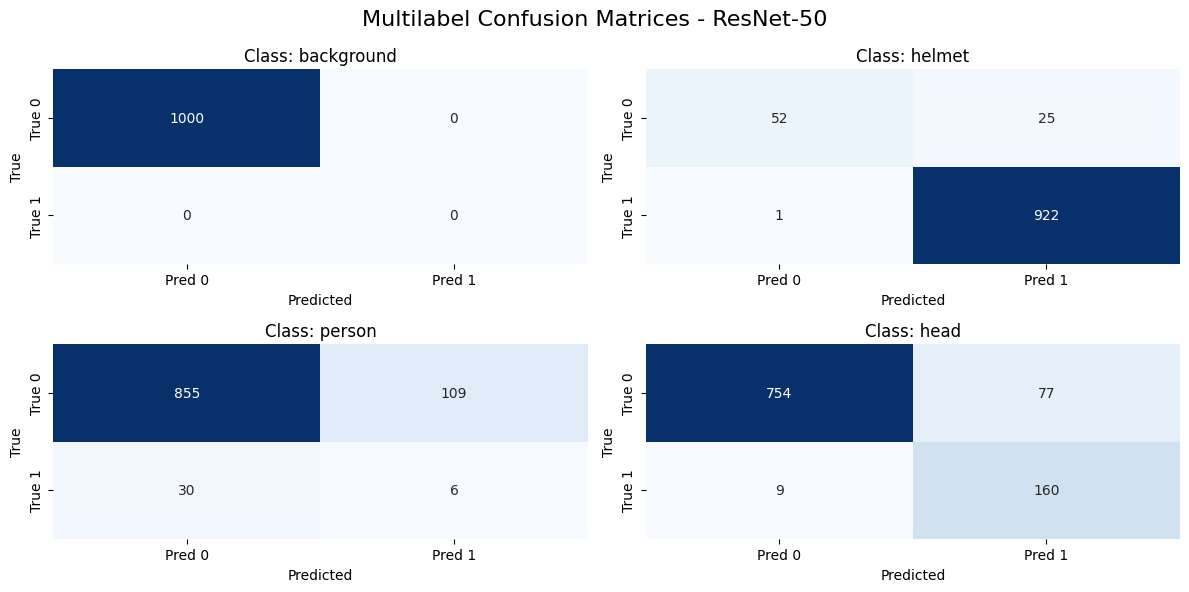

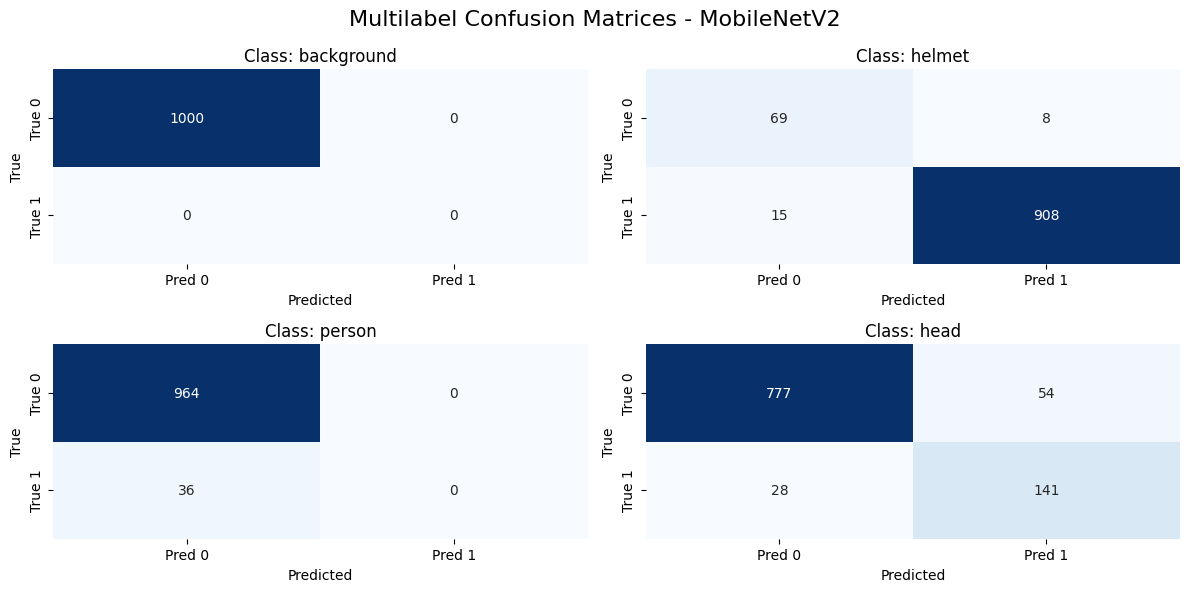

In [75]:
cm_resnet   = get_per_class_confusion_matrices(model_resnet, val_loader, device, CLASS_MAP)
cm_mobilenet = get_per_class_confusion_matrices(model_mobilenet, val_loader, device, CLASS_MAP)

plot_confusion_matrix(cm_resnet,   REV_CLASS_MAP, 'ResNet-50')
plot_confusion_matrix(cm_mobilenet, REV_CLASS_MAP, 'MobileNetV2')


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.47s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.75 | area=   all | maxDets=100 ] = 0.501
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.75 | area= small | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50:0.75 | area=medium | maxDets=100 ] = 0.573
 Average Precision  (AP) @[ IoU=0.50:0.75 | area= large | maxDets=100 ] = 0.625
 Average Recall     (AR) @[ IoU=0.50:0.75 | area=   all | maxDets=  1 ] = 0.131
 Average Recall     (AR) @[ IoU=0.50:0.75 | area=   all | maxDets= 10 ] = 0.511
 Average Recall     (AR) @[ IoU=0.50:0.75 | area=   all | maxDe

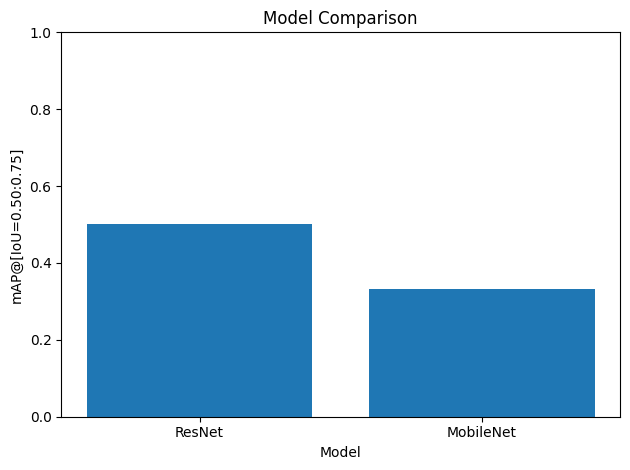

In [100]:
import os
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

def coco_eval_and_plot(gt_path, dt_paths, labels, iou_thrs=[0.5, 0.75]):
    """
    Evaluate each detection file in dt_paths against the same ground truth,
    extract the mAP@[IoU=50:75] (stats[0]), and plot a bar chart.
    """
    scores = []
    for dt in dt_paths:
        cocoGt   = COCO(gt_path)
        cocoDt   = cocoGt.loadRes(dt)
        cocoEval = COCOeval(cocoGt, cocoDt, 'bbox')
        # override the IoU thresholds
        cocoEval.params.iouThrs = iou_thrs  
        cocoEval.evaluate()
        cocoEval.accumulate()
        cocoEval.summarize()           # ← this populates cocoEval.stats
        scores.append(cocoEval.stats[0])
    
    # make sure labels match
    assert len(labels) == len(scores), "labels and dt_paths must have same length"
    
    # plotting
    plt.figure()
    plt.bar(labels, scores)
    plt.ylabel('mAP@[IoU=0.50:0.75]')
    plt.xlabel('Model')
    plt.title('Model Comparison')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

# Usage:
coco_eval_and_plot(
    gt_path='val_gt.json',
    dt_paths=['resnet_preds.json', 'mobilenet_preds.json'],
    labels=['ResNet', 'MobileNet']
)
